# Import packages & functions

In [1]:
# pip install matplotlib numpy torch torchvision torchaudio

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

import ddp_config
distributed,local_rank = ddp_config.ddp_test()
if device=='cuda': torch.cuda.set_device(local_rank)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

seed=42
utils.seed_everything(seed=seed)

/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
NOT using distributed parallel processing!


## Load CLIP extractor

In [3]:
clip_extractor = Clipper("ViT-L/14", 
                         clamp_embs=False, 
                         norm_embs=False, 
                         device=device)

ViT-L/14 cuda


# CLIP retrieval evaluation

### Load model checkpoint

In [4]:
# model_name = "prior-w-voxel2clip"

# outdir = f'../train_logs/models/{model_name}/test'

# ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
# print("ckpt_path",ckpt_path)

# checkpoint = torch.load(ckpt_path, map_location=device)

# # utils.plot_brainnet_ckpt(ckpt_path)

### Load pretrained weights onto model

In [5]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
# diffusion_prior = BrainDiffusionPrior.from_pretrained(
#     dict(),
#     dict(
#         condition_on_text_encodings=False,
#         timesteps=1000,
#         voxel2clip=voxel2clip,
#     ),
# )

# diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
# diffusion_prior.eval().to(device)
# print("loaded")

def load_prior(ckpt_path):
    utils.plot_prior_ckpt(ckpt_path)
    
    diffusion_prior = BrainDiffusionPrior.from_pretrained(
        # kwargs for DiffusionPriorNetwork
        dict(),
        # kwargs for DiffusionNetwork
        dict(
            condition_on_text_encodings=False,
            timesteps=1000,
            voxel2clip=voxel2clip,
        ),
        ckpt_dir='../src/checkpoints/',
    )

    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt['model_state_dict']
    
    # fix DDP keys
    for key in list(state_dict.keys()):
        if 'module.' in key:
            state_dict[key.replace('module.', '')] = state_dict[key]
            del state_dict[key]
    
    diffusion_prior.load_state_dict(state_dict)
    diffusion_prior.eval().to(device);
    return diffusion_prior

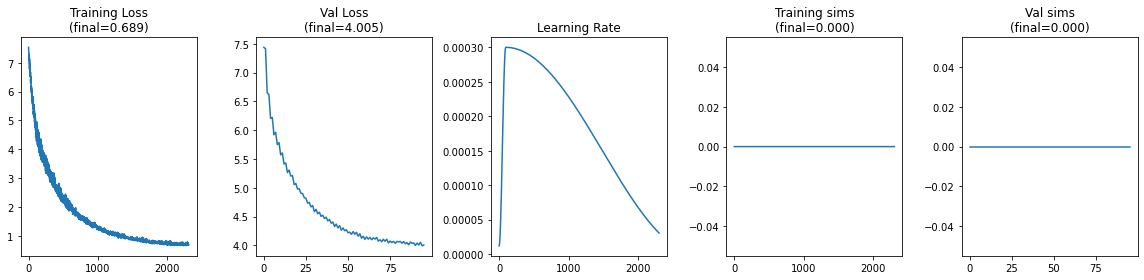

In [6]:
diffusion_prior_img = load_prior('../train_logs/models/prior-w-voxel2clip/1D_combo-image/ckpt-best.pth')

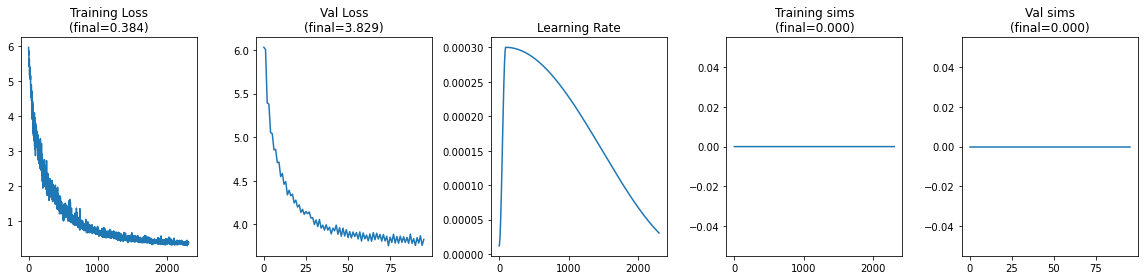

In [7]:
diffusion_prior_txt = load_prior('../train_logs/models/prior-w-voxel2clip/1D_combo-text/ckpt-best.pth')

### Prep data loader

In [8]:
batch_size = 300 # same as used in mind_reader

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 8
num_workers 8
batch_size 300
val_batch_size 300
global_batch_size 2400
num_worker_batches 1
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 2


/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


idx 0
voxel.shape torch.Size([300, 15724])
img_input.shape torch.Size([300, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


## Forward / Backward quantification

In [9]:
for diffusion_prior in [diffusion_prior_img, diffusion_prior_txt]:
    percent_correct_fwd, percent_correct_bwd = None, None

    for val_i, (voxel, img, trial) in enumerate(val_dl):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                voxel = voxel.to(device)

                emb = clip_extractor.embed_image(img) # CLIP-Image

                #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text

                # l2norm + scaling 
                emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) * diffusion_prior.image_embed_scale

                labels = torch.arange(len(emb)).to(device)
                bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
                fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

                if percent_correct_fwd is None:
                    cnt=1
                    percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                    percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
                else:
                    cnt+=1
                    percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                    percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
    percent_correct_fwd /= cnt
    percent_correct_bwd /= cnt
    print("fwd percent_correct", percent_correct_fwd)
    print("bwd percent_correct", percent_correct_bwd)

fwd percent_correct tensor(0.2067, device='cuda:0')
bwd percent_correct tensor(0.2617, device='cuda:0')
fwd percent_correct tensor(0.2067, device='cuda:0')
bwd percent_correct tensor(0.2617, device='cuda:0')


### Plot some of the results

Forward retrieval


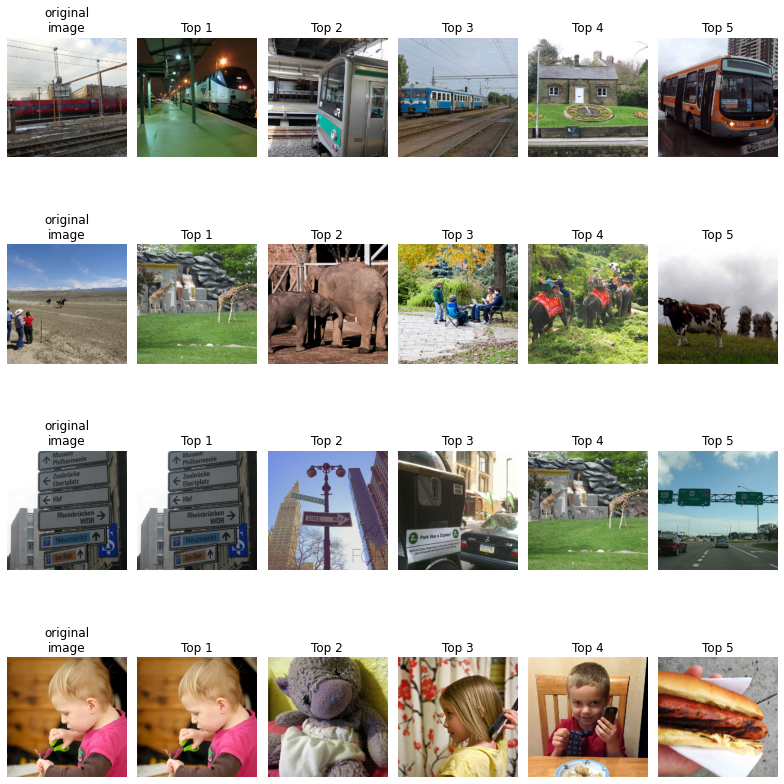

In [10]:
print("Forward retrieval")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval


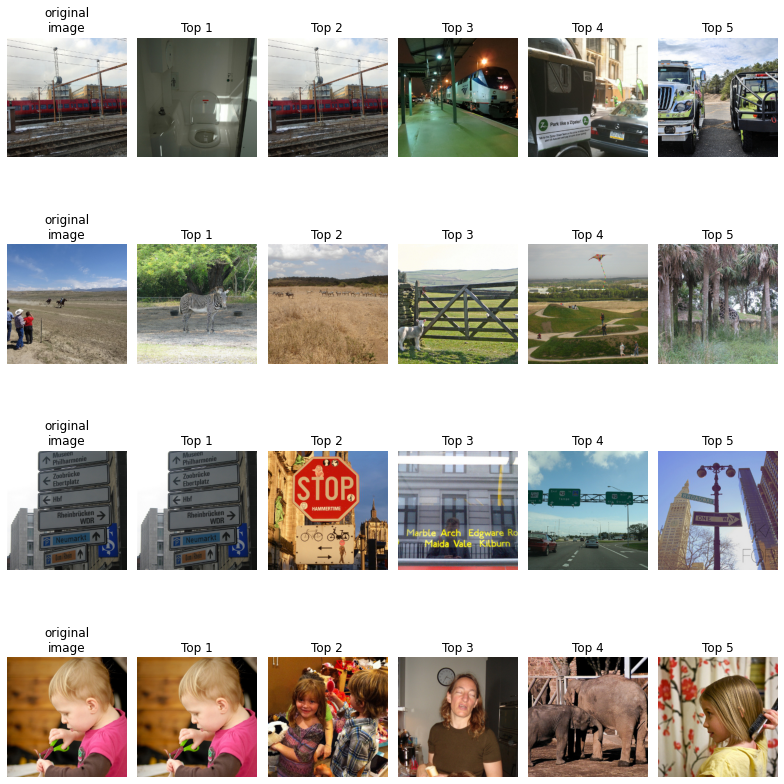

In [11]:
print("Backward retrieval")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# Reconstruction evaluation

### Load model checkpoint

In [12]:
# model_name = "prior-w-voxel2clip"

# outdir = f'../train_logs/models/{model_name}/test'

# ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
# print("ckpt_path",ckpt_path)

# checkpoint = torch.load(ckpt_path, map_location=device)

# # utils.plot_brainnet_ckpt(ckpt_path)

### Load pretrained weights onto model

In [13]:
# voxel2clip = BrainNetwork(out_dim=768)

# # need folder "checkpoints" with following files
# # wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# # wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
# diffusion_prior = BrainDiffusionPrior.from_pretrained(
#     dict(),
#     dict(
#         condition_on_text_encodings=False,
#         timesteps=1000,
#         voxel2clip=voxel2clip,
#     ),
# )

# diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
# diffusion_prior.eval().to(device)
# print("loaded")

### Prep data loader

In [29]:
batch_size = 4

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_val_samples=4, # should be None!
#         seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
#         seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 8
num_workers 8
batch_size 4
val_batch_size 4
global_batch_size 32
num_worker_batches 97
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 123


/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


idx 0
voxel.shape torch.Size([4, 15724])
img_input.shape torch.Size([4, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


### Load SD variations model

In [15]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

#sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
sd_cache_dir = '/scratch/gpfs/ps6938/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
    from diffusers import StableDiffusionImageVariationPipeline
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", revision="v2.0")
    sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

torch_dtype = torch.float16 ## use this so we have enough memory for two diffusion priors
unet = UNet2DConditionModel.from_pretrained(sd_cache_dir, subfolder="unet", torch_dtype=torch_dtype).to(device)
vae = AutoencoderKL.from_pretrained(sd_cache_dir, subfolder="vae", torch_dtype=torch_dtype).to(device)
noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)

unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae.eval()
vae.requires_grad_(False)
print("loaded")

Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 9491.33it/s]


loaded


## Reconstruction via diffusion, one at a time
This will take awhile!!

In [20]:
def reconstruct_first_batch(diffusion_priors):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    all_images = None
    all_clip_recons = None
    all_brain_recons = None
    recons_per_clip = 1
    recons_per_brain = 4
    # for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
                img_input, voxel,
                diffusion_priors, 
                clip_extractor, unet, vae, noise_scheduler,
                img_lowlevel = None,
                num_inference_steps = 20,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .6,
                timesteps = 1000,
                seed = seed,
                distributed = distributed,
    #             plotting = True,
            )
            # grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
            if all_brain_recons is None:
                all_brain_recons = brain_recons
                all_clip_recons = clip_recons
                all_images = img
            else:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
                all_images = torch.vstack((all_images,img))

    all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
    all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

#     torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
#     torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
#     torch.save(all_images,f'{outdir}/all_images')

    print("all_brain_recons.shape",all_brain_recons.shape)
    print("all_clip_recons.shape",all_clip_recons.shape)
    print("all_images.shape",all_images.shape)
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) #35 seconds

2023-03-13 20:08:53
all_brain_recons.shape torch.Size([1, 16, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([300, 3, 256, 256])
2023-03-13 20:09:33


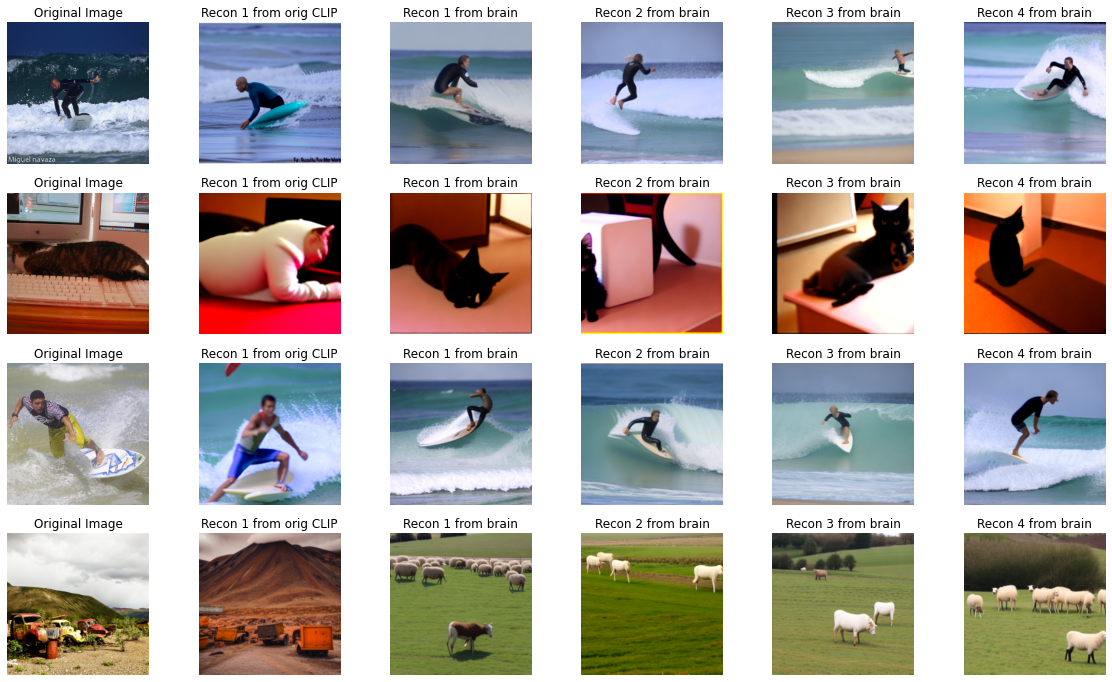

In [21]:
reconstruct_first_batch(diffusion_prior_img)

2023-03-13 20:09:33
all_brain_recons.shape torch.Size([1, 16, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([300, 3, 256, 256])
2023-03-13 20:10:14


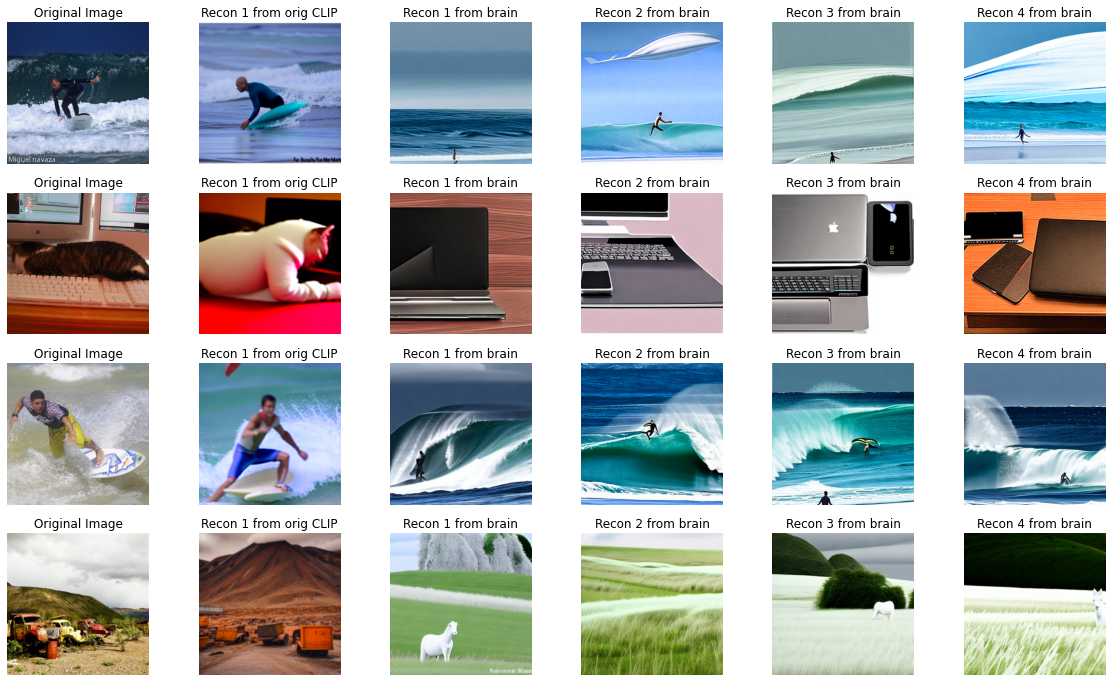

In [22]:
reconstruct_first_batch(diffusion_prior_txt)

2023-03-13 20:10:14
all_brain_recons.shape torch.Size([1, 16, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([300, 3, 256, 256])
2023-03-13 20:11:16


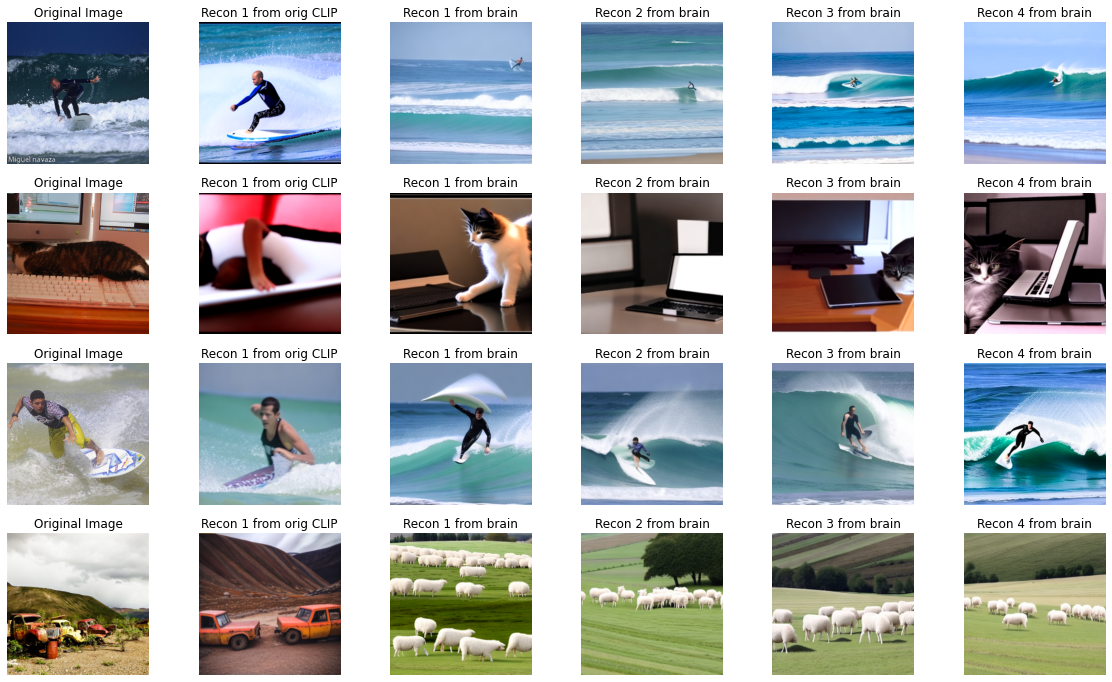

In [23]:
reconstruct_first_batch([diffusion_prior_img, diffusion_prior_txt])

In [25]:
outdir = '../train_logs/eval-NB-img'
!mkdir $outdir

In [ ]:
import utils
import importlib
importlib.reload(utils)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
for val_i, (voxel, img, trial) in tqdm(enumerate(val_dl)):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
                img, voxel,
                diffusion_prior_img, 
                clip_extractor, unet, vae, noise_scheduler,
                img_lowlevel = None,
                num_inference_steps = 20,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .6,
                timesteps = 1000,
                seed = seed,
                distributed = distributed,
    #             plotting = True,
                retrieve=False,
            )
            grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
            plt.close()
            if all_brain_recons is None:
                all_brain_recons = brain_recons
                all_clip_recons = clip_recons
                all_images = img
            else:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
                all_images = torch.vstack((all_images,img))
#     break

all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) # 36 seconds

2023-03-13 20:24:08


20it [13:43, 41.22s/it]/fsx/jimgoo/git/fMRI-reconstruction-NSD/src/utils.py:796: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(n_samples_save, num_xaxis_subplots,
51it [35:18, 42.11s/it]

In [ ]:
torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
torch.save(all_images,f'{outdir}/all_images')

In [ ]:
# load variables if above cell was previously completed
all_brain_recons = torch.load(f'{outdir}/all_brain_recons')
all_clip_recons = torch.load(f'{outdir}/all_clip_recons')
all_images = torch.load(f'{outdir}/all_images')

## FID evaluation

In [28]:
import  pytorch_fid_wrapper as pfw

# using last feature layer (2048-dim) before FCs, as used in mind_reader
# can lower batch size if needed for memory
pfw.set_config(batch_size=all_images.shape[0], dims=2048, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(all_brain_recons[:,0].float(), real_images=all_images.float())
print(val_fid)

/fsx/nev/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/nev/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


250.69992841162411


## 2-way identification

In [29]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():        
                real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
                fake = model(preprocess(recon[0]).unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = model(preprocess(all_brain_recons[rand_idx,0]).unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake)
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

def two_way_identification_clip(all_brain_recons, all_images, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():       
                real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
                fake = clip_extractor.embed_image(recon[0].unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = clip_extractor.embed_image(all_brain_recons[rand_idx,0].unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake.item())
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

### AlexNet

In [30]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
preprocess = weights.transforms()

layer = 'late' # corresponds to layers used in Takagi & Nishimoto
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
model.avgpool=nn.Identity()
model.classifier=nn.Identity()
print(model)

# all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
        
# print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
# print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /admin/home-nev/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 100MB/s]  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): Identity()
    (10): Identity()
    (11): Identity()
    (12): Identity()
  )
  (avgpool): Identity()
  (classifier): Identity()
)


### InceptionV3

In [31]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=30)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /admin/home-nev/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 410MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

100%|██████████| 30/30 [41:55<00:00, 83.85s/it]

2-way Percent Correct (mu, std): 0.56 | 0.03
Avg l2dist_fake (mu, std): 0.0148 | 0.0000


### CLIP

In [32]:
all_per_correct, all_l2dist_list = tw o_way_identification_clip(all_brain_recons, all_images, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

100%|██████████| 10/10 [01:10<00:00,  7.00s/it]

2-way Percent Correct (mu, std): 0.67 | 0.02
Avg l2dist_fake (mu, std): 0.0244 | 0.0000
